In [1]:
import os
if 'examples' in os.getcwd(): os.chdir('../..')
print(os.getcwd())

import warnings
warnings.filterwarnings('ignore')

/home/bernie40916/Nas/home/Project/DJtransGAN


In [2]:
import torch
import matplotlib.pyplot as plt

from djtransgan.config    import settings
from djtransgan.utils     import wave_visualize, mask_visualize
from djtransgan.mixer     import VMask, HMask
from djtransgan.frontend  import get_amp2db_func, get_stft_func
from djtransgan.dataset   import get_dataset, batchlize

## Preparation 

In [3]:
stft_func   = get_stft_func()
amp2db_func = get_amp2db_func()

STFT kernels created, time used = 0.1708 seconds


### Data Prepareing

In [4]:
n_time       = 10
batch_size   = 4 

dataset      = get_dataset('noise', n_time=n_time)
dataloader   = iter(batchlize(dataset, batch_size))
waves        = next(dataloader)
mags, phases = stft_func(waves) # (batch_size, channels, bins, frames)

print('waves size: ', waves.size())
print('mags size: ' , mags.size())

size:  torch.Size([4, 1, 441000])
mags:  torch.Size([4, 1, 1025, 862])


## VMask

### VMask Usage

In [5]:
n_band  = 3 
n_param = 2 # each eq has two parameters (Cutoff_freq, Q_factor)

In [6]:
vmask   = VMask('mean', 'low', 'linear', 'equal')
params  = torch.rand(batch_size, n_band - 1, n_param)
vmags, vmasks, vcurves, vfcurves = vmask(mags, params)

print('mag : ', vmags.size())
print('mask: ', vmasks.size())
print('curve: ', vcurves.size())

mag :  torch.Size([4, 3, 1, 1025, 862])
mask:  torch.Size([4, 3, 1, 1025, 862])
curve:  torch.Size([4, 3, 1, 1025])


### VMask Visualize

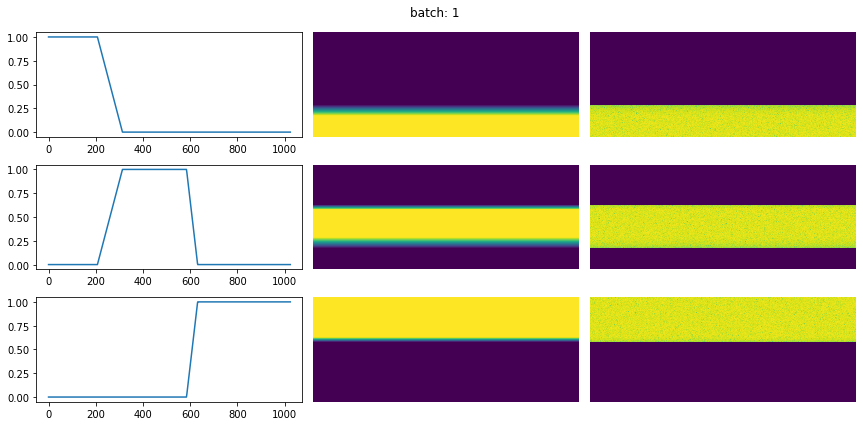

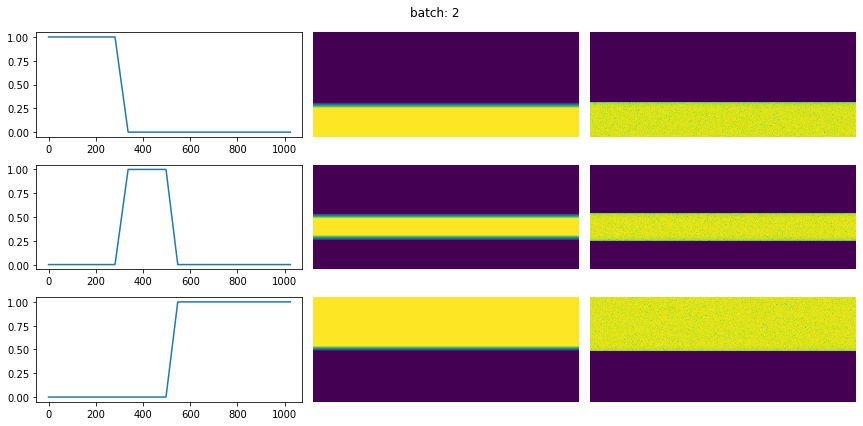

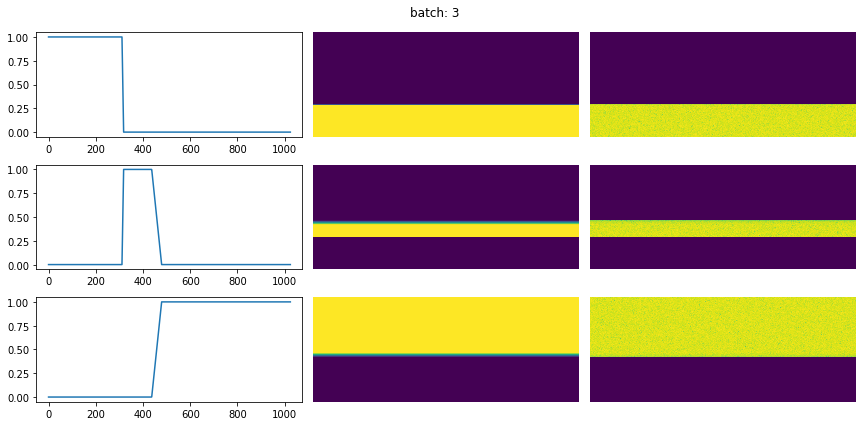

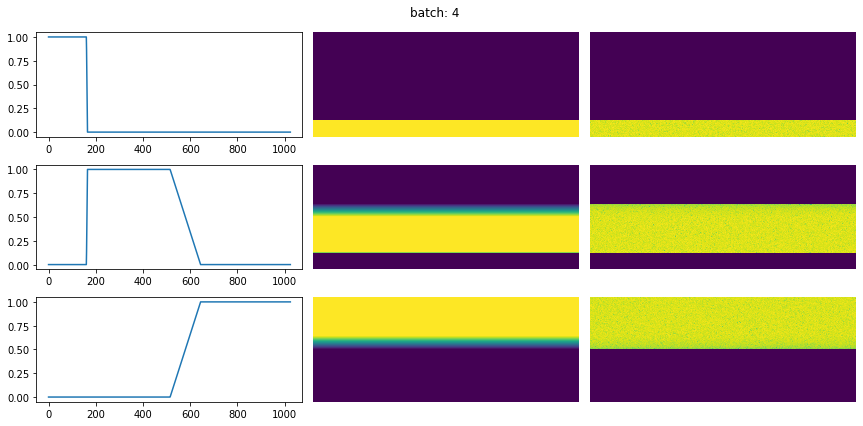

In [7]:
for batch_idx in range(batch_size):
    fig, axes = plt.subplots(n_band, 3, figsize=(12, 6))
    for (mag, mask, curve, ax) in zip(vmags[batch_idx], vmasks[batch_idx], vcurves[batch_idx], axes):
        ax[0].plot(curve[0])
        mask_visualize(mask[0], ax[1])
        mask_visualize(amp2db_func(mag[0]), ax[2])
    plt.suptitle(f'batch: {batch_idx + 1}')
    plt.tight_layout()
    plt.show()

### Check Differentiability

In [8]:
params  = torch.rand(batch_size, n_band - 1, n_param, requires_grad=True)
vmags, vmasks, vcurves, vfcurves = vmask(mags, params)
vmags.backward(torch.ones_like(vmags))
print(f'grad: {params.grad is not None}')

grad: True


## HMask

### Data Prepareing

In [9]:
n_band    = 2
n_fader   = 1

In [10]:
band_mags = torch.stack([mags for i in range(n_band)], axis=1) # (batch_size, bands, channels, bins, frames)

print('band_mags: ', band_mags.size())

band_mags:  torch.Size([4, 2, 1, 1025, 862])


### HMask Usage

In [11]:
hmask   = HMask('sum', 'fi', 'linear')
params  = torch.rand(batch_size, n_band, n_fader, n_param)
hmags, hmasks, hcurves = hmask(band_mags, params)


print('mag : ' , hmags.size())
print('mask: ' , hmasks.size())
print('curve: ', hcurves.size())

mag :  torch.Size([4, 2, 1, 1025, 862])
mask:  torch.Size([4, 2, 1, 1025, 862])
curve:  torch.Size([4, 2, 1, 862])


### HMask Visualize

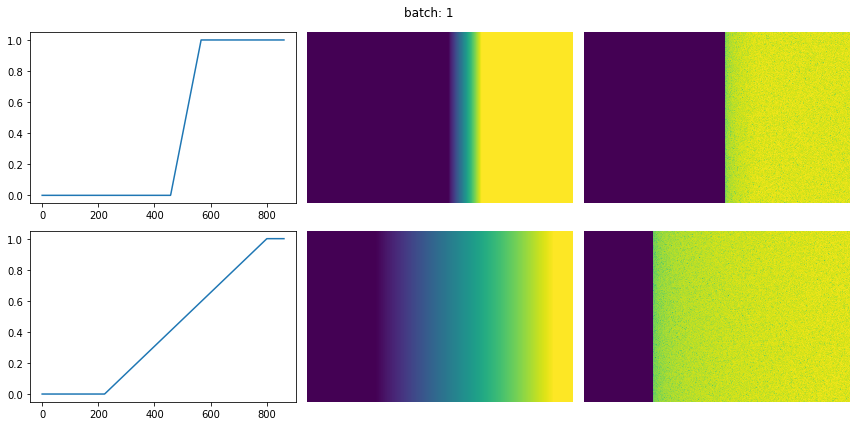

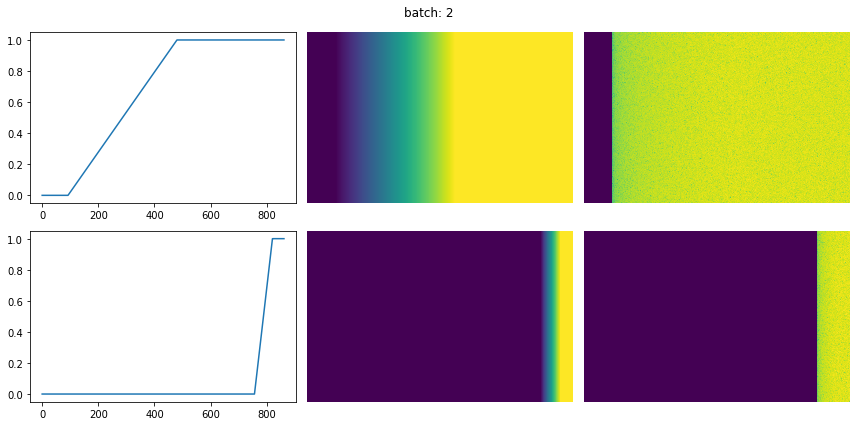

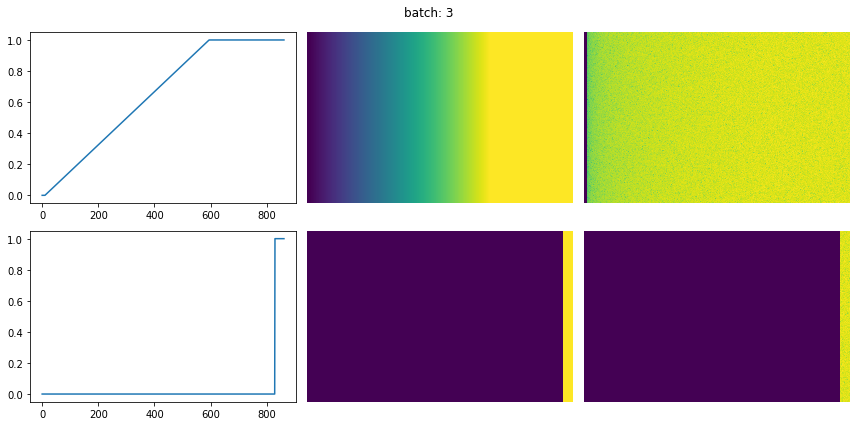

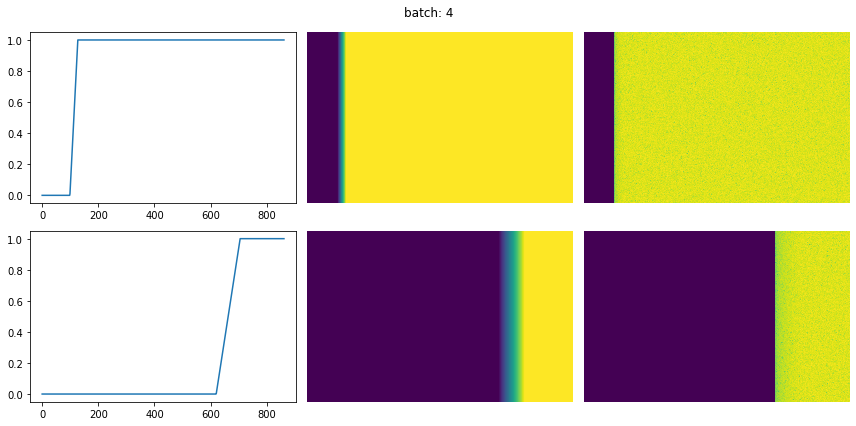

In [12]:
for batch_idx in range(batch_size):
    fig, axes = plt.subplots(n_band, 3, figsize=(12, 6))
    for (mag, mask, curve, ax) in zip(hmags[batch_idx], hmasks[batch_idx], hcurves[batch_idx], axes):
        ax[0].plot(curve[0])
        mask_visualize(mask[0], ax[1])
        mask_visualize(amp2db_func(mag[0]), ax[2])
    plt.suptitle(f'batch: {batch_idx+1}')
    plt.tight_layout()
    plt.show()

### Check Differentiability

In [13]:
params  = torch.rand(batch_size, n_band, n_fader, n_param, requires_grad=True)
hmags, hmasks, hcurves = hmask(band_mags, params)
hmags.backward(torch.ones_like(hmags))

print(f'grad: {params.grad is not None}')

grad: True
